# Identifying Hostnames

In the previous notebook, we saw how we could perform passive analysis on netflow data. We saw how we could find out what were the most commonly accessed IP addresses. Unfortunately, knowing the most popular often is not very useful because these IP addresses belong to CDNs.

In this notebook, we will see how we can map flows to the hostnames using data (DNS queries/responses, and TLS handshakes) collected passively from network devices. We will also see how we can use PySpark to perform analysis at scale

## Background

To learn about PySpark, please refer to [this amazing quickstart tutorial](https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html)

## PySpark setup

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .config("spark.driver.memory", '4G') \
    .config("spark.ui.killEnabled", False) \
    .getOrCreate()
spark.sparkContext.setLogLevel('OFF')

22/04/22 09:31:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Read the packet capture

In [2]:
df = spark.read.parquet("data/0.parquet")

In [3]:
df.show(n=5)

+-------------------+----------+-----+----------+-----+------+--------+---------+----------+----------+------------+------------+------+
|                 ts|       sIP|sPort|       dIP|dPort|ip_len|ip_proto|tcp_flags|   tcp_seq|   tcp_ack|tls_hostname|dns_hostname|dns_ip|
+-------------------+----------+-----+----------+-----+------+--------+---------+----------+----------+------------+------------+------+
|1.650605988970132E9|2154771547|   22|2850491930|61423|   176|       6|       24| 466497284|1004105560|        null|        null|  null|
|1.650605988974799E9|2850491930|61423|2154771547|   22|    52|       6|       16|1004105560| 466497408|        null|        null|  null|
|1.650605989605509E9|2154771547|   22|2154771491|49460|   928|       6|       24|1339330825| 841584044|        null|        null|  null|
|1.650605989605979E9|2154771491|49460|2154771547|   22|    52|       6|       16| 841584044|1339331701|        null|        null|  null|
|1.650605990609014E9|2154771547|   22|215

## DNS queries and responses

When a user writes a URL, the client issues a DNS query to resolve that URL. The DNS queries and responses help us identify the hostnames the IP addresses correspond.

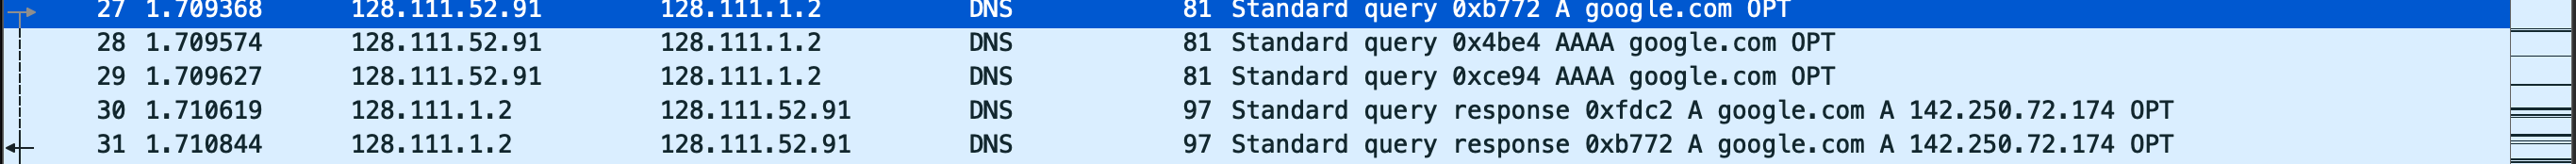

In [4]:
df.select('dns_hostname').distinct().show()

+--------------------+
|        dns_hostname|
+--------------------+
|www.facebook.com,...|
|accounts.google.c...|
|0d7a523f-12e4-49b...|
|                null|
|www.youtube.com,y...|
|maps.google.com,<...|
|googlemail.l.goog...|
|dyna.wikimedia.or...|
|   google.com,<Root>|
|star-mini.c10r.fa...|
|www.wikipedia.org...|
|fb.com,fb.com,fb....|
|  youtube.com,<Root>|
|mail.google.com,g...|
|5d177f74-ba4d-4e0...|
|play.google.com,<...|
|www.google.com,<R...|
|wikipedia.com,<Root>|
|              <Root>|
|www.youtube.com,y...|
+--------------------+
only showing top 20 rows



In [5]:
df.select('dns_ip').distinct().show()

+----------+
|    dns_ip|
+----------+
|3324189282|
|2398804366|
|      null|
|2154771549|
|2398824485|
|2398824484|
|3324189280|
|2398767278|
| 520963620|
|2398793741|
|2398767246|
|2398824494|
+----------+



In [6]:
ip2hostname_df = df.select('dns_ip', 'dns_hostname').filter(df.dns_ip.isNotNull())

In [7]:
ip2hostname_df.show()

+----------+--------------------+
|    dns_ip|        dns_hostname|
+----------+--------------------+
|2398767278|   google.com,<Root>|
|2398767278|   google.com,<Root>|
|2398824484|www.google.com,<R...|
|2398767246|  youtube.com,<Root>|
|2398767246|  youtube.com,<Root>|
|2398767246|  youtube.com,<Root>|
|3324189282|wikipedia.com,<Root>|
|3324189282|wikipedia.com,<Root>|
|3324189282|wikipedia.com,<Root>|
|3324189280|www.wikipedia.org...|
|3324189280|www.wikipedia.org...|
|3324189280|dyna.wikimedia.or...|
| 520963620|www.facebook.com,...|
| 520963620|www.facebook.com,...|
| 520963620|star-mini.c10r.fa...|
|2398804366|maps.google.com,<...|
|2398804366|maps.google.com,<...|
|2398824484|www.google.com,<R...|
|2398824484|www.google.com,<R...|
|2398824494|play.google.com,<...|
+----------+--------------------+
only showing top 20 rows



With the above dataframe, you can use a [join operation](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.join.html) such that each flow has the corresponding hostname in a single dataframe

### [WIP] View IP Addresses as String

In [8]:
import ipaddress
from pyspark.sql.types import StringType

@F.udf()
def ip_int_to_str(ip_int):
    try:
        return str(ipaddress.ip_address(ip_int))
    except ValueError:
        return None

In [9]:
ip2hostname_df = ip2hostname_df.withColumn('dns_ip', ip_int_to_str(df['dns_ip']).cast(StringType()))

In [12]:
ip2hostname_df.show()

## TLS Handshakes

In the TLS Handshake, when the client says Hello, the client specifies the [Server Name Indication](https://en.wikipedia.org/wiki/Server_Name_Indication) (SNI). The Server Name Identification (e.g. youtube.com) is the hostname with which the client is looking to connect.

By having the server name identification field, one IP address can be used to serve different content. The server differentiates the content to serve by looking at the SNI field value.

In [6]:
df.select('tls_hostname').distinct().show()

+-------------------+
|       tls_hostname|
+-------------------+
|accounts.google.com|
|    play.google.com|
|        youtube.com|
|      wikipedia.com|
|   en.wikipedia.org|
|               null|
|    www.youtube.com|
|     www.google.com|
|   www.facebook.com|
|             fb.com|
|    mail.google.com|
|  www.wikipedia.org|
+-------------------+



In [ ]:
flow2hostname_df = df.select(
    'sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname').filter(df.tls_hostname.isNotNull())

In [15]:
df.select(
    'sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname').filter(df.tls_hostname.isNotNull()).show()

+----------+-----+----------+-----+--------+-------------------+
|       sIP|sPort|       dIP|dPort|ip_proto|       tls_hostname|
+----------+-----+----------+-----+--------+-------------------+
|2154771547|60992|2398767246|  443|       6|        youtube.com|
|2154771547|57290|2398766126|  443|       6|    www.youtube.com|
|2154771547|43568|3324189282|  443|       6|      wikipedia.com|
|2154771547|59710|3324189280|  443|       6|  www.wikipedia.org|
|2154771547|33896|2649752355|  443|       6|             fb.com|
|2154771547|55012| 520963620|  443|       6|   www.facebook.com|
|2154771547|40904|2398824484|  443|       6|     www.google.com|
|2154771547|40906|2398824484|  443|       6|     www.google.com|
|2154771547|39084|2398824494|  443|       6|    play.google.com|
|2154771547|39086|2398824494|  443|       6|    play.google.com|
|2154771547|39088|2398824494|  443|       6|    play.google.com|
|2154771547|59188|2398824485|  443|       6|    mail.google.com|
|2154771547|59190|2398824